In [86]:
# Importing all the necessary libraries
import numpy as np
import pandas as pd
from collections import Counter
from datetime import datetime
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
import xgboost
from xgboost import plot_importance
from xgboost import XGBClassifier
import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import auc, roc_curve, classification_report
import math
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator

#import sys
#!{sys.executable} -m pip install cufflinks
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
# import cufflinks and offline mode
import cufflinks as cf
cf.go_offline()

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from collections import Counter

from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
from keras.callbacks import EarlyStopping

## Goal

These are the tasks you are aksed to do:
- For each user, determine her country based on the numeric IP address.
- Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs. false negatives would impact the model.
- You boss is a bit worried about using a model, she doesn't understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a methematical perspective, but from a user perspective. What kinds of users are more likely to be classified as at risk? What are their charactersitics?
- Let's say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? I.e., what kind of different user experiences would you build based on the model output?

In [55]:
fraud = pd.read_csv('Fraud.csv', index_col = [0])
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
1,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
2,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
3,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
4,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
5,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [56]:
ip = pd.read_csv('IpAddress_to_Country.csv')
ip.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [59]:
country = []
for i in range(len(fraud)):
    ip_temp = fraud['ip_address'].iloc[i]
    temp = ip[(ip['lower_bound_ip_address']<=ip_temp) & (ip['upper_bound_ip_address']>=ip_temp)]
    if len(temp)==1:
        country.append(temp['country'].values[0])
    else:
        country.append(None)
fraud['country'] = country

In [60]:
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
1,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
2,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
3,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
4,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,None
5,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [61]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151112 entries, 1 to 151112
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
 11  country         129146 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 15.0+ MB


In [62]:
fraud['signup_time'] = pd.to_datetime(fraud['signup_time'])
fraud['purchase_time'] = pd.to_datetime(fraud['purchase_time'])

In [67]:
fraud.country.value_counts()

United States        58049
China                12038
Japan                 7306
United Kingdom        4490
Korea Republic of     4162
                     ...  
Myanmar                  1
Vanuatu                  1
Dominica                 1
Niger                    1
Guadeloupe               1
Name: country, Length: 181, dtype: int64

We can see some visit is from very rare countries.

### Build a model to predict whether an activity is fraudulent or not.

Before jumping into building a model, think about whether you can create new powerful variables. This is called feature engineering and it is the most important step in machine learning.

#### Feature Engineering
- Time difference between sign-up time and purchase time
- If the device ID is unique or certain users are sharing the same device (many different user ids using the same device could be an indicator of fake accounts)
- Same for the ip address.
- Usual week of the year and day of the week from time variables.

In [71]:
# Time difference
fraud['time_diff'] = (fraud['purchase_time'] - fraud['signup_time']).dt.total_seconds()

In [76]:
# check for each device id how many different user had it
n_dev_shared = fraud.device_id.value_counts()
fraud['n_dev_shared'] = fraud['device_id'].map(n_dev_shared)
del fraud['device_id']

In [78]:
# check for ip address how many different user had it
n_ip_shared = fraud.ip_address.value_counts()
fraud['n_ip_shared'] = fraud['ip_address'].map(n_ip_shared)
del fraud['ip_address']

In [82]:
fraud['signup_day'] = fraud['signup_time'].apply(lambda x: x.dayofweek)
fraud['signup_week'] = fraud['signup_time'].apply(lambda x: x.week)

fraud['purchase_day'] = fraud['purchase_time'].apply(lambda x: x.dayofweek)
fraud['purchase_week'] = fraud['purchase_time'].apply(lambda x: x.week)

In [84]:
del fraud['signup_time']
del fraud['purchase_time']

In [87]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM JBR-11.0.13.7-1751.21-jcef (build 11.0.13+7-b1751.21, mixed mode)
  Starting server from C:\Users\yijia\anaconda3\envs\py3-TF2.0\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\yijia\AppData\Local\Temp\tmpj6c07sq_
  JVM stdout: C:\Users\yijia\AppData\Local\Temp\tmpj6c07sq_\h2o_yijia_started_from_python.out
  JVM stderr: C:\Users\yijia\AppData\Local\Temp\tmpj6c07sq_\h2o_yijia_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,13 days
H2O_cluster_name:,H2O_from_python_yijia_9sdouc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.912 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [90]:
# Transform to H2O Frame, and make sure the target variable is categorical
df = H2OFrame(fraud)
for col in ['signup_day', 'purchase_day', 'source', 'browser', 'sex', 'country', 'class']:
    df[col] = df[col].asfactor()
df.summary()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


,user_id,purchase_value,source,browser,sex,age,class,country,time_diff,n_dev_shared,n_ip_shared,signup_day,signup_week,purchase_day,purchase_week
type,int,int,enum,enum,enum,int,enum,enum,real,int,int,enum,int,enum,int
mins,2.0,9.0,,,,18.0,,,1.0,1.0,1.0,,1.0,,1.0
mean,200171.04096961123,36.93537243898572,,,,33.14070358409664,,,4932029.248623589,1.6843665625496338,1.3041849753825028,,16.501740430938597,,24.65857112605206
maxs,400000.0,154.0,,,,76.0,,,10367972.0,20.0,13.0,,34.0,,51.0
sigma,115369.28502413504,18.32276214866212,,,,8.617733490961491,,,3126263.118444302,2.61695360280417,1.3672671245454835,,9.81428746179891,,11.651556782719457
zeros,0,0,,,,0,,,0,0,0,,0,,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,22058.0,34.0,SEO,Chrome,M,39.0,0,Japan,4506682.0,1.0,1.0,1,9.0,5,16.0
1,333320.0,16.0,Ads,Chrome,F,53.0,0,United States,17944.0,1.0,1.0,6,23.0,0,24.0
2,1359.0,15.0,SEO,Opera,M,53.0,1,United States,1.0,12.0,8.0,3,1.0,3,1.0


In [91]:
# Split into 70% training and 30% test data

temp_split =  df['class'].stratified_split(test_frac = 0.3, seed = 20220722)
train = df[temp_split == 'train']
test = df[temp_split == 'test']

# Define features and target
feature = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 
           'source', 'browser', 'sex', 'age', 'country', 'time_diff', 'n_dev_shared', 'n_ip_shared']
target = 'class'

In [92]:
# Build random forest model 
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, mtries=-1, stopping_rounds=5, 
                                 stopping_metric='auc', score_each_iteration=True, seed=42)
model.train(x=feature, y=target, training_frame=train, validation_frame=test)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1658504102685_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,28.0,28.0,1778010.0,20.0,20.0,20.0,3324.0,4853.0,4030.8215




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.1081991859702551
RMSE: 0.3289364467040025
LogLoss: 0.31419672185297987
Mean Per-Class Error: 0.0338380372171423
AUC: 0.9955013024999106
AUCPR: 0.9954466517905302
Gini: 0.9910026049998213

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.056459385398165356: 


,,0,1,Error,Rate
0,0,91279.0,4593.0,0.0479,(4593.0/95872.0)
1,1,1897.0,94064.0,0.0198,(1897.0/95961.0)
2,Total,93176.0,98657.0,0.0338,(6490.0/191833.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.056459,0.966653,333.0
1,max f2,0.043798,0.979778,342.0
2,max f0point5,0.097946,0.966904,309.0
3,max accuracy,0.056459,0.966168,333.0
4,max precision,0.840849,0.999982,40.0
5,max recall,0.016883,1.000000,373.0
6,max specificity,1.000000,0.999990,0.0
7,max absolute_mcc,0.056459,0.932705,333.0
8,max min_per_class_accuracy,0.069431,0.962724,325.0
9,max mean_per_class_accuracy,0.056459,0.966162,333.0



Gains/Lift Table: Avg response rate: 50.02 %, avg score: 36.58 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.272647,1.000000,1.999045,1.999045,0.999981,1.000000,0.999981,1.000000,0.545034,0.545034,99.904474,99.904474,0.545023
1,2,0.299999,0.737170,1.997940,1.998944,0.999428,0.856527,0.999930,0.986919,0.054647,0.599681,99.793997,99.894401,0.599639
2,3,0.400002,0.255103,1.984390,1.995305,0.992650,0.469800,0.998110,0.857636,0.198445,0.798126,98.438995,99.530540,0.796614
3,4,0.500000,0.068396,1.650913,1.926428,0.825835,0.139007,0.963656,0.713913,0.165088,0.963214,65.091343,92.642844,0.926854
4,5,0.599998,0.027200,0.364114,1.666047,0.182140,0.040325,0.833406,0.601650,0.036411,0.999625,-63.588616,66.604720,0.799621
5,6,0.700001,0.018159,0.003543,1.428540,0.001772,0.022214,0.714597,0.518871,0.000354,0.999979,-99.645700,42.853953,0.600232
6,7,0.799999,0.011849,0.000208,1.250002,0.000104,0.014932,0.625288,0.455880,0.000021,1.000000,-99.979158,25.000163,0.400186
7,8,0.899997,0.005671,0.000000,1.111115,0.000000,0.008897,0.555812,0.406216,0.000000,1.000000,-100.000000,11.111497,0.200098
8,9,1.000000,0.000000,0.000000,1.000000,0.000000,0.002088,0.500229,0.365802,0.000000,1.000000,-100.000000,0.000000,0.000000




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.040839349283819715
RMSE: 0.20208747928513462
LogLoss: 0.19051230880402326
Mean Per-Class Error: 0.23131054401549928
AUC: 0.8394682595705412
AUCPR: 0.7084147529277826
Gini: 0.6789365191410823

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2867511777994921: 


,,0,1,Error,Rate
0,0,41080.0,8.0,0.0002,(8.0/41088.0)
1,1,1963.0,2282.0,0.4624,(1963.0/4245.0)
2,Total,43043.0,2290.0,0.0435,(1971.0/45333.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.286751,0.698393,32.0
1,max f2,0.041481,0.653089,212.0
2,max f0point5,0.456437,0.851766,17.0
3,max accuracy,0.303726,0.956544,29.0
4,max precision,1.000000,1.000000,0.0
5,max recall,0.000006,1.000000,399.0
6,max specificity,1.000000,1.000000,0.0
7,max absolute_mcc,0.303726,0.715049,29.0
8,max min_per_class_accuracy,0.023171,0.758539,273.0
9,max mean_per_class_accuracy,0.039181,0.814513,216.0



Gains/Lift Table: Avg response rate:  9.36 %, avg score:  6.96 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.049059,1.000000,10.679152,10.679152,1.000000,1.000000,1.000000,1.000000,0.523910,0.523910,967.915194,967.915194,0.523910
1,2,0.050008,0.608995,10.430800,10.674441,0.976744,0.952147,0.999559,0.999092,0.009894,0.533804,943.079957,967.444125,0.533780
2,3,0.100015,0.057747,2.449563,6.562002,0.229378,0.104129,0.614468,0.551611,0.122497,0.656302,144.956286,556.200205,0.613759
3,4,0.150001,0.032556,1.055662,4.727095,0.098853,0.040495,0.442647,0.381289,0.052768,0.709069,5.566197,372.709520,0.616828
4,5,0.200009,0.027671,0.405120,3.646482,0.037936,0.029808,0.341458,0.293409,0.020259,0.729329,-59.487999,264.648223,0.584006
5,6,0.300002,0.022545,0.341601,2.544936,0.031988,0.024870,0.238309,0.203903,0.034158,0.763486,-65.839907,154.493614,0.511369
6,7,0.399996,0.019014,0.379295,2.003556,0.035517,0.020698,0.187614,0.158104,0.037927,0.801413,-62.070517,100.355567,0.442890
7,8,0.500011,0.016120,0.306195,1.664039,0.028672,0.017523,0.155821,0.129984,0.030624,0.832038,-69.380464,66.403868,0.366330
8,9,0.600004,0.013456,0.353380,1.445612,0.033091,0.014780,0.135368,0.110785,0.035336,0.867373,-64.661972,44.561167,0.294992
9,10,0.699998,0.010923,0.362804,1.290935,0.033973,0.012182,0.120884,0.096699,0.036278,0.903651,-63.719625,29.093457,0.224694




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-07-22 11:41:09,0.075 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2022-07-22 11:41:10,1.270 sec,1.0,0.315875,0.775305,0.961426,0.946590,1.924319,0.095299,0.258666,1.808393,0.779772,0.483184,7.277050,0.064721
2,,2022-07-22 11:41:11,1.890 sec,2.0,0.324600,0.668624,0.963474,0.952362,1.940410,0.091661,0.211548,0.687691,0.810108,0.652891,10.218535,0.045530
3,,2022-07-22 11:41:11,2.331 sec,3.0,0.316760,0.602135,0.968733,0.958868,1.948356,0.081383,0.206689,0.503754,0.820373,0.673864,10.521286,0.044294
4,,2022-07-22 11:41:11,2.630 sec,4.0,0.320513,0.548333,0.970295,0.962988,1.958197,0.079706,0.204488,0.377401,0.823372,0.683202,10.618075,0.043941
5,,2022-07-22 11:41:12,2.988 sec,5.0,0.321674,0.487382,0.974288,0.968812,1.967746,0.074697,0.203533,0.326787,0.825975,0.688755,10.669689,0.043743
6,,2022-07-22 11:41:12,3.160 sec,6.0,0.321046,0.435538,0.977918,0.974105,1.976118,0.070321,0.203175,0.299808,0.826197,0.690812,10.679152,0.043677
7,,2022-07-22 11:41:12,3.337 sec,7.0,0.322351,0.404523,0.980493,0.977763,1.981630,0.067283,0.202938,0.280206,0.827770,0.693067,10.679152,0.044096
8,,2022-07-22 11:41:12,3.520 sec,8.0,0.321268,0.379984,0.982931,0.980897,1.985545,0.065529,0.202831,0.263842,0.829485,0.694973,10.679152,0.043853
9,,2022-07-22 11:41:12,3.709 sec,9.0,0.323070,0.363687,0.984910,0.983442,1.988870,0.062056,0.202735,0.253660,0.830616,0.696239,10.679152,0.043677



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,n_dev_shared,249962.750000,1.000000,0.302039
1,time_diff,122848.382812,0.491467,0.148442
2,n_ip_shared,93939.617188,0.375814,0.113511
3,signup_week,89948.281250,0.359847,0.108688
4,purchase_week,78833.882812,0.315383,0.095258
5,country,61675.195312,0.246738,0.074524
6,purchase_value,27411.013672,0.109660,0.033122
7,age,27045.570312,0.108198,0.032680
8,signup_day,26060.806641,0.104259,0.031490
9,purchase_day,20627.460938,0.082522,0.024925


In [93]:
model.score_history()

,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-07-22 11:41:09,0.075 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2022-07-22 11:41:10,1.270 sec,1.0,0.315875,0.775305,0.961426,0.946590,1.924319,0.095299,0.258666,1.808393,0.779772,0.483184,7.277050,0.064721
2,,2022-07-22 11:41:11,1.890 sec,2.0,0.324600,0.668624,0.963474,0.952362,1.940410,0.091661,0.211548,0.687691,0.810108,0.652891,10.218535,0.045530
3,,2022-07-22 11:41:11,2.331 sec,3.0,0.316760,0.602135,0.968733,0.958868,1.948356,0.081383,0.206689,0.503754,0.820373,0.673864,10.521286,0.044294
4,,2022-07-22 11:41:11,2.630 sec,4.0,0.320513,0.548333,0.970295,0.962988,1.958197,0.079706,0.204488,0.377401,0.823372,0.683202,10.618075,0.043941
5,,2022-07-22 11:41:12,2.988 sec,5.0,0.321674,0.487382,0.974288,0.968812,1.967746,0.074697,0.203533,0.326787,0.825975,0.688755,10.669689,0.043743
6,,2022-07-22 11:41:12,3.160 sec,6.0,0.321046,0.435538,0.977918,0.974105,1.976118,0.070321,0.203175,0.299808,0.826197,0.690812,10.679152,0.043677
7,,2022-07-22 11:41:12,3.337 sec,7.0,0.322351,0.404523,0.980493,0.977763,1.981630,0.067283,0.202938,0.280206,0.827770,0.693067,10.679152,0.044096
8,,2022-07-22 11:41:12,3.520 sec,8.0,0.321268,0.379984,0.982931,0.980897,1.985545,0.065529,0.202831,0.263842,0.829485,0.694973,10.679152,0.043853
9,,2022-07-22 11:41:12,3.709 sec,9.0,0.323070,0.363687,0.984910,0.983442,1.988870,0.062056,0.202735,0.253660,0.830616,0.696239,10.679152,0.043677


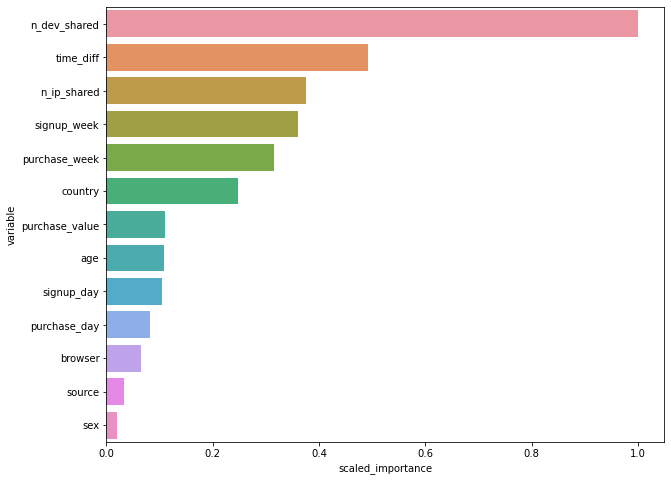

In [94]:
# Feature importance
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()

In [95]:
# Make predictions 
train_true = train.as_data_frame()['class'].values
test_true = test.as_data_frame()['class'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [96]:
# Classification report
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     41088
           1       1.00      0.53      0.70      4245

    accuracy                           0.96     45333
   macro avg       0.98      0.77      0.84     45333
weighted avg       0.96      0.96      0.95     45333



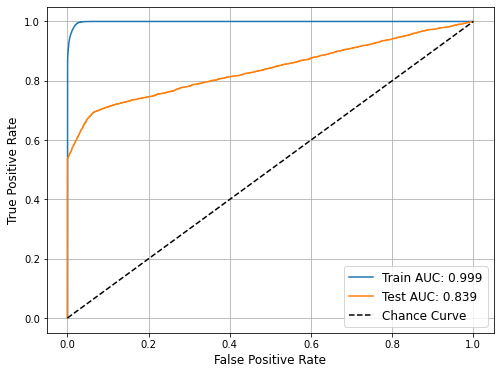

In [97]:
train_fpr = np.insert(train_fpr, 0, 0)
train_tpr = np.insert(train_tpr, 0, 0)
test_fpr = np.insert(test_fpr, 0, 0)
test_tpr = np.insert(test_tpr, 0, 0)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.plot(train_fpr, train_fpr, 'k--', label='Chance Curve')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.grid(True)
ax.legend(fontsize=12)
plt.show()

In [100]:
# Shutdown h2o instance
h2o.cluster().shutdown()

H2O session _sid_947a closed.


Based on the ROC, if we care about minimizing false positive, we would choose a cut-off that would give us true positive rate of ~0.5 and the false positive rate almost 0. 
However, if we care about maximizing true positive, we have to decrease the cutoff.

In [99]:
from sklearn.preprocessing import LabelEncoder
for feature in fraud.select_dtypes(include='object'):
    lbl_enc = LabelEncoder()
    lbl_enc.fit(fraud[feature])
    fraud[feature] = lbl_enc.transform(fraud[feature])

In [101]:
# Define features and target
feature = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 
           'source', 'browser', 'sex', 'age', 'country', 'time_diff', 'n_dev_shared', 'n_ip_shared']
target = 'class'

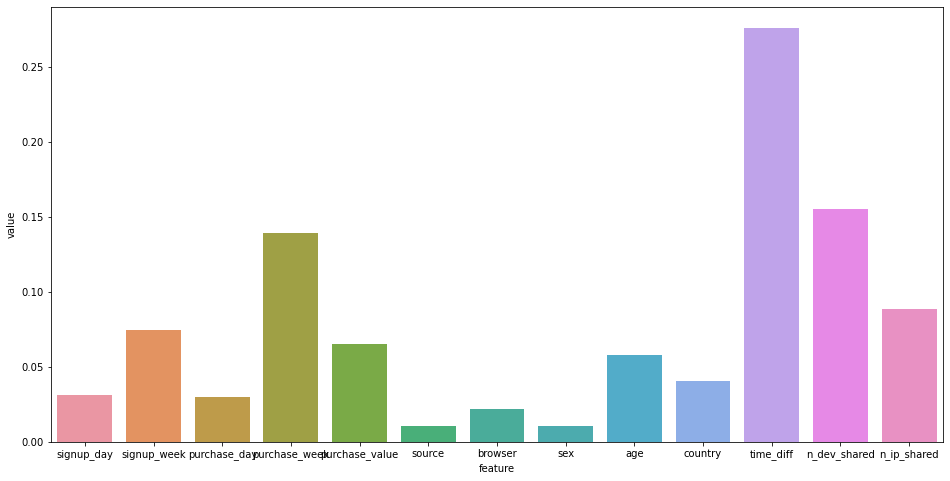

In [102]:
model = RandomForestClassifier()
model.fit(fraud[feature], fraud[target])
feature_importances = model.feature_importances_
columns = ['feature', 'value']
importance = pd.DataFrame(feature_importances, index=feature).reset_index()
importance.columns = columns
fig = plt.figure(figsize = (16, 8))
sns.barplot(x='feature', y ='value', data=importance)
plt.show()